In [848]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna
import torch.utils.data as utils

# for LSTM reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:4096:2
%env CUDA_LAUNCH_BLOCKING=1
        
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

env: CUBLAS_WORKSPACE_CONFIG=:4096:2
env: CUDA_LAUNCH_BLOCKING=1


<ipython-input-848-c3b0ea2d3d79>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [849]:
def load_nasdaq(use_fed_data = True):
    filepath = 'input/NASDAQ_DAYLY.csv'
    nasdaq = pd.read_csv(filepath)
    nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
    #nasdaq = nasdaq[nasdaq['Date'] > datetime.datetime(2010, 1, 1)]
    nasdaq = nasdaq.set_index('Date')
    nasdaq = nasdaq[['Close']]
    filepath = 'input/WALCL.csv'
    assets = pd.read_csv(filepath)
    assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
    assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
    assets.set_index('Date',inplace=True)
    nasdaq['Assets'] = assets['Millions_of_Dollars']
    nasdaq = nasdaq.dropna()
    scaled = nasdaq.copy()
    scaler1 = MinMaxScaler(feature_range=(min(nasdaq['Close'])/max(nasdaq['Close']), 1))
    #scaler1 = MinMaxScaler(feature_range=(0.1, 1))
    scaler2 = MinMaxScaler(feature_range=(min(nasdaq['Assets'])/max(nasdaq['Assets']), 1))
    #scaler2 = MinMaxScaler(feature_range=(0.1, 1))
    scaled ['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
    scaled ['Assets'] = scaler2.fit_transform(scaled['Assets'].values.reshape(-1,1))
    if not use_fed_data:
        del nasdaq['Assets']
        del scaled['Assets']
    return nasdaq, scaled, scaler1, scaler2    
        
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  

In [850]:
nasdaq

,Close,Assets
Date,,
2002-12-18,1013.669983,719542.0
2003-01-08,1042.520020,723762.0
2003-01-15,1073.599976,720074.0
2003-01-22,1006.510010,735953.0
2003-01-29,1016.559998,712809.0
...,...,...
2021-05-26,13702.740234,7903541.0
2021-06-02,13675.790039,7935703.0
2021-06-09,13814.940430,7952327.0


In [851]:
scaled

,Close,Assets
Date,,
2002-12-18,0.071014,0.088811
2003-01-08,0.073035,0.089332
2003-01-15,0.075212,0.088877
2003-01-22,0.070512,0.090837
2003-01-29,0.071216,0.087980
...,...,...
2021-05-26,0.959963,0.975512
2021-06-02,0.958075,0.979481
2021-06-09,0.967823,0.981533


In [852]:
# function to create train, test data given stock data and sequence lengt
def load_data(stock, look_back, batch_size, prev_perm = None ,use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back + 1): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    np.random.seed(seed)
    if prev_perm is not None:
        rand_perm = prev_perm
    else:
        rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train_full = data[:train_set_size,:-1,:]
    y_train_full = data[:train_set_size,-1,:]
    y_train_full = y_train_full[:,0].reshape(-1,1)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    y_test = y_test[:,0].reshape(-1,1)
    
    
    x_train_full = torch.from_numpy(x_train_full).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train_full = torch.from_numpy(y_train_full).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    train_loader = utils.DataLoader(utils.TensorDataset(x_train_full,y_train_full),batch_size=batch_size)
    
      
    
    return [x_test, y_test, x_train_full, y_train_full], train_loader
[x_test, y_test, x_train_full, y_train_full], train_loader
[x_test, y_test, x_train_full, y_train_full], train_loader = load_data(nasdaq, 10, 8)
print(len(train_loader))

95


In [853]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [854]:
def objective(trial):
    look_back = trial.suggest_int("Look Back",10,50,step=5)
    batch_size = trial.suggest_categorical('Batch Size', [8,16,32,64,128,256])
    hidden_dim = trial.suggest_categorical('Hidden Dim', [8,16,32,64,128,256])
    num_layers = trial.suggest_int("N layers",1,3)
    lr = trial.suggest_float("Learning Rate",1e-4,0.1,log=True)
    num_iters = 2000 #trial.suggest_int("Num Iters",2000,2000,step=500)
    factor = trial.suggest_float('Factor',0.55,0.95,step=0.1)
    #patience = trial.suggest_int("Patience",5,5)
    
    [x_test, y_test, _, _], train_loader= load_data(scaled, look_back, batch_size, use_perm=True)
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = min(num_iters//len(train_loader),100)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data,target) in enumerate(train_loader):

            # Forward pass
            y_train_pred = model(data)
            MSE_loss = loss_fn(y_train_pred, target)
            loss = torch.sqrt(MSE_loss)
            train_loss += MSE_loss.item()
            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            
        train_loss = math.sqrt(train_loss/len(train_loader))
        y_test_pred = model(x_test)
        test_loss = torch.sqrt(loss_fn(y_test_pred, y_test)).item()
        scheduler.step(test_loss)
        trial.report(test_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return test_loss

In [855]:
# now we can run the experiment
def conduct_study (study_name, model_name, n_trials = 500, timeout=180*60):
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(study_name=study_name, direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials, timeout=timeout)

    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    return study

In [856]:
def train(best_trial, model_name):
    look_back = best_trial.params['Look Back']
    batch_size = best_trial.params['Batch Size']
    hidden_dim = best_trial.params['Hidden Dim']
    num_layers = best_trial.params['N layers']
    lr = best_trial.params['Learning Rate']
    num_iters = 2000 #best_trial.params["Num Iters"]
    factor = best_trial.params['Factor']
    #patience = best_trial.params['Patience']
    
    [x_test, y_test, x_train_full, y_train_full], train_loader = load_data(scaled, look_back, batch_size, use_perm=True)
    
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = min(num_iters//len(train_loader),100)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
    hist = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data,target) in enumerate(train_loader):

            # Forward pass
            y_train_pred = model(data)
            MSE_loss = loss_fn(y_train_pred, target)
            loss = torch.sqrt(MSE_loss)
            train_loss += MSE_loss.item()
            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            
        train_loss = math.sqrt(train_loss/len(train_loader))
        y_test_pred = model(x_test)
        test_loss = torch.sqrt(loss_fn(y_test_pred, y_test)).item()
        scheduler.step(test_loss)
        
        if epoch % 20 == 0:
            print("Epoch ", epoch, "MSE: ", train_loss)
        hist[epoch] = train_loss
        if epoch == num_epochs-1:
            print("Last Epoch ", epoch, "MSE: ", train_loss)
    
    # plot loss
    plt.semilogy(hist, label="Training loss")
    plt.legend()
    plt.show()
    
    # make predictions
    y_test_pred = model(x_test)
    y_train_pred = model(x_train_full)
    # invert predictions

    y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler1.inverse_transform(y_train_full.detach().cpu().numpy())
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())
    return y_train_pred, y_train, y_test_pred, y_test, model
    #return [x_train, y_train, x_test, y_test, x_train_full, y_train_full], model

In [857]:
def plot_results(model, batch_size, last = 20):
    [x_test, y_test, _, _], _ = load_data(scaled, look_back, batch_size, use_perm = False)
    y_test_pred = model(x_test)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('NASDAQ-100 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[-last:].index, y_test[-last:], '.', color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[-last:].index, y_test_pred[-last:], '.', color = 'blue', label = 'Predicted NASDAQ Price')
    plt.title('NASDAQ-100 Stock Price Prediction - Last Weeks')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()

In [858]:
def predict_results(model, n=5):
    data_raw = scaled.values
    predictions = []
    data = np.array(data_raw[len(data_raw) - look_back:])
    x_test = data.reshape(1,data.shape[0],data.shape[1])
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    for _ in range(n):
        y_test_pred = model(x_test)
        if input_dim == 2:
            tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
        elif input_dim ==1: 
            tmp = torch.tensor([[[y_test_pred[0,0].item()]]]).to(device)
        x_test = torch.cat((x_test,tmp),1)[:,1:,:]
        y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
        predictions.append(y_test_pred.item())
        
    figure, axes = plt.subplots(figsize=(15, 6))
    print(predictions)
    axes.plot(range(1,n+1),predictions)
    plt.xticks(range(1,n+1))
    plt.xlabel('Weeks Ahead')
    plt.ylabel('NASDAQ-100 Stock Price Prediction')

# Prediction with GRU

In [859]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  
input_dim = 2

In [860]:
study_gru = conduct_study('GRU', 'GRU')

[I 2021-06-26 00:02:02,963] A new study created in memory with name: GRU
[I 2021-06-26 00:02:10,412] Trial 0 finished with value: 0.01093936339020729 and parameters: {'Look Back': 40, 'Batch Size': 64, 'Hidden Dim': 16, 'N layers': 3, 'Learning Rate': 0.014903752389444387, 'Factor': 0.8500000000000001}. Best is trial 0 with value: 0.01093936339020729.
[I 2021-06-26 00:02:16,801] Trial 1 finished with value: 0.011914259754121304 and parameters: {'Look Back': 45, 'Batch Size': 64, 'Hidden Dim': 16, 'N layers': 2, 'Learning Rate': 0.06016722991767261, 'Factor': 0.55}. Best is trial 0 with value: 0.01093936339020729.
[I 2021-06-26 00:02:26,524] Trial 2 finished with value: 0.025661779567599297 and parameters: {'Look Back': 15, 'Batch Size': 64, 'Hidden Dim': 256, 'N layers': 3, 'Learning Rate': 0.02707396482591285, 'Factor': 0.65}. Best is trial 0 with value: 0.01093936339020729.
[I 2021-06-26 00:02:29,995] Trial 3 finished with value: 0.012341630645096302 and parameters: {'Look Back': 10,

[I 2021-06-26 00:04:46,072] Trial 50 finished with value: 0.008956605568528175 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 128, 'N layers': 1, 'Learning Rate': 0.003255128110306947, 'Factor': 0.65}. Best is trial 47 with value: 0.008554506115615368.
[I 2021-06-26 00:04:50,694] Trial 51 finished with value: 0.010829566046595573 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 128, 'N layers': 1, 'Learning Rate': 0.003469817779126429, 'Factor': 0.65}. Best is trial 47 with value: 0.008554506115615368.
[I 2021-06-26 00:04:51,141] Trial 52 pruned. 
[I 2021-06-26 00:04:55,861] Trial 53 finished with value: 0.009694032371044159 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 128, 'N layers': 1, 'Learning Rate': 0.00307957840170375, 'Factor': 0.55}. Best is trial 47 with value: 0.008554506115615368.
[I 2021-06-26 00:04:56,105] Trial 54 pruned. 
[I 2021-06-26 00:04:56,761] Trial 55 pruned. 
[I 2021-06-26 00:05:01,494] Trial 56 finished with

[I 2021-06-26 00:06:21,030] Trial 124 pruned. 
[I 2021-06-26 00:06:21,261] Trial 125 pruned. 
[I 2021-06-26 00:06:21,294] Trial 126 pruned. 
[I 2021-06-26 00:06:21,526] Trial 127 pruned. 
[I 2021-06-26 00:06:21,766] Trial 128 pruned. 
[I 2021-06-26 00:06:22,239] Trial 129 pruned. 
[I 2021-06-26 00:06:26,857] Trial 130 finished with value: 0.009618444368243217 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006335812454291811, 'Factor': 0.65}. Best is trial 62 with value: 0.00846871268004179.
[I 2021-06-26 00:06:31,509] Trial 131 finished with value: 0.010168063454329967 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.0065517779591086085, 'Factor': 0.65}. Best is trial 62 with value: 0.00846871268004179.
[I 2021-06-26 00:06:36,075] Trial 132 finished with value: 0.009297593496739864 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rat

[I 2021-06-26 00:08:08,560] Trial 197 finished with value: 0.008495395071804523 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006427153874711654, 'Factor': 0.65}. Best is trial 62 with value: 0.00846871268004179.
[I 2021-06-26 00:08:13,137] Trial 198 finished with value: 0.008988067507743835 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.0062796037411296645, 'Factor': 0.65}. Best is trial 62 with value: 0.00846871268004179.
[I 2021-06-26 00:08:17,629] Trial 199 finished with value: 0.008439116179943085 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.009344917275269657, 'Factor': 0.65}. Best is trial 199 with value: 0.008439116179943085.
[I 2021-06-26 00:08:17,861] Trial 200 pruned. 
[I 2021-06-26 00:08:18,101] Trial 201 pruned. 
[I 2021-06-26 00:08:18,340] Trial 202 pruned. 
[I 2021-06-26 00:08:18,576] Trial 203 pruned. 

[I 2021-06-26 00:09:20,897] Trial 297 pruned. 
[I 2021-06-26 00:09:21,348] Trial 298 pruned. 
[I 2021-06-26 00:09:21,391] Trial 299 pruned. 
[I 2021-06-26 00:09:21,844] Trial 300 pruned. 
[I 2021-06-26 00:09:22,087] Trial 301 pruned. 
[I 2021-06-26 00:09:22,323] Trial 302 pruned. 
[I 2021-06-26 00:09:22,576] Trial 303 pruned. 
[I 2021-06-26 00:09:22,829] Trial 304 pruned. 
[I 2021-06-26 00:09:23,071] Trial 305 pruned. 
[I 2021-06-26 00:09:23,316] Trial 306 pruned. 
[I 2021-06-26 00:09:23,399] Trial 307 pruned. 
[I 2021-06-26 00:09:23,652] Trial 308 pruned. 
[I 2021-06-26 00:09:23,914] Trial 309 pruned. 
[I 2021-06-26 00:09:24,259] Trial 310 pruned. 
[I 2021-06-26 00:09:24,506] Trial 311 pruned. 
[I 2021-06-26 00:09:24,913] Trial 312 pruned. 
[I 2021-06-26 00:09:25,159] Trial 313 pruned. 
[I 2021-06-26 00:09:25,401] Trial 314 pruned. 
[I 2021-06-26 00:09:25,636] Trial 315 pruned. 
[I 2021-06-26 00:09:25,904] Trial 316 pruned. 
[I 2021-06-26 00:09:30,547] Trial 317 finished with value: 0

[I 2021-06-26 00:10:34,881] Trial 403 pruned. 
[I 2021-06-26 00:10:35,353] Trial 404 pruned. 
[I 2021-06-26 00:10:35,582] Trial 405 pruned. 
[I 2021-06-26 00:10:35,816] Trial 406 pruned. 
[I 2021-06-26 00:10:36,050] Trial 407 pruned. 
[I 2021-06-26 00:10:36,302] Trial 408 pruned. 
[I 2021-06-26 00:10:40,815] Trial 409 finished with value: 0.011514239944517612 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.0075395112191451496, 'Factor': 0.65}. Best is trial 199 with value: 0.008439116179943085.
[I 2021-06-26 00:10:45,431] Trial 410 finished with value: 0.011242533102631569 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.011065792627498457, 'Factor': 0.65}. Best is trial 199 with value: 0.008439116179943085.
[I 2021-06-26 00:10:45,665] Trial 411 pruned. 
[I 2021-06-26 00:10:45,798] Trial 412 pruned. 
[I 2021-06-26 00:10:50,738] Trial 413 finished with value: 0.010481898672878742

[I 2021-06-26 00:11:47,916] Trial 498 pruned. 
[I 2021-06-26 00:11:48,006] Trial 499 pruned. 


Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  411
  Number of complete trials:  89


In [861]:
print("Best trial:")
trial_gru = study_gru.best_trial

print("Loss: ", trial_gru.value)
print(trial_gru.params)

Best trial:
Loss:  0.008439116179943085
{'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.009344917275269657, 'Factor': 0.65}


In [862]:
optuna.visualization.plot_param_importances(study_gru)

Epoch  0 MSE:  0.10650480051014283
Epoch  20 MSE:  0.011909763602118333
Last Epoch  20 MSE:  0.011909763602118333


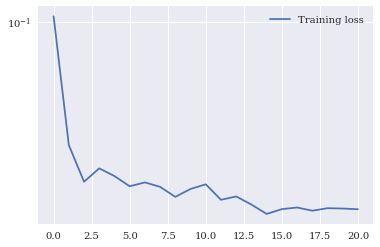

In [863]:
y_train_pred, y_train, y_test_pred, y_test, gru = train(trial_gru, "GRU")

In [864]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('GRU Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('GRU Test Score: %.2f RMSE' % (testScore))

GRU Train Score: 134.95 RMSE
GRU Test Score: 120.46 RMSE


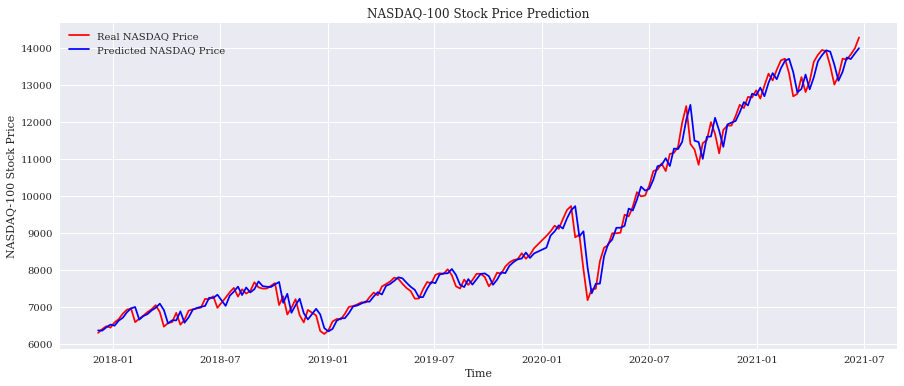

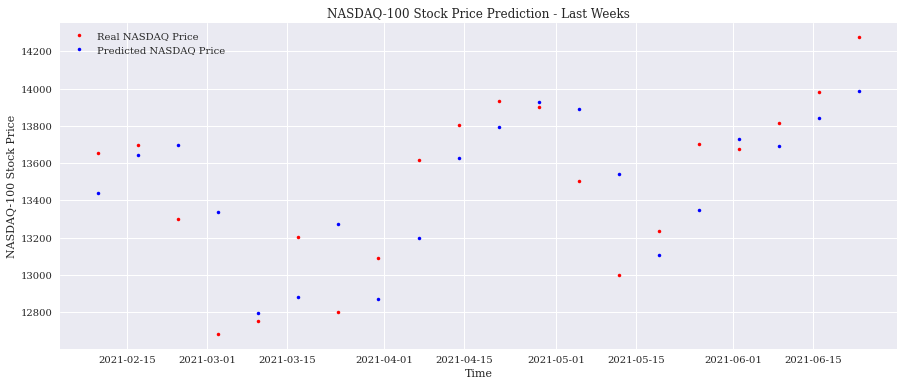

In [865]:
plot_results(gru, batch_size = trial_gru.params['Batch Size'])

[14254.482421875, 14222.4755859375, 14216.4013671875, 14211.53125, 14212.466796875]


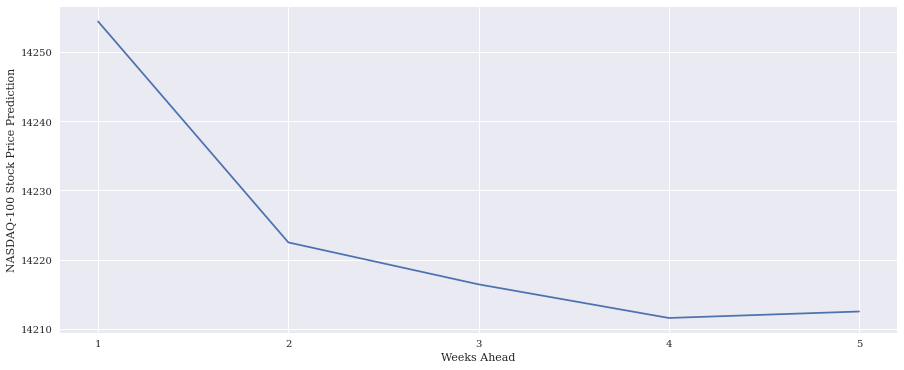

In [866]:
predict_results(gru)

# Prediction with LSTM

In [867]:
study_lstm = conduct_study ('LSTM', 'LSTM')

[I 2021-06-26 00:11:55,721] A new study created in memory with name: LSTM
[I 2021-06-26 00:12:00,111] Trial 0 finished with value: 0.012805557809770107 and parameters: {'Look Back': 15, 'Batch Size': 64, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.00021049814396998103, 'Factor': 0.55}. Best is trial 0 with value: 0.012805557809770107.
[I 2021-06-26 00:12:06,310] Trial 1 finished with value: 0.012362835928797722 and parameters: {'Look Back': 10, 'Batch Size': 32, 'Hidden Dim': 8, 'N layers': 2, 'Learning Rate': 0.009146639549409209, 'Factor': 0.95}. Best is trial 1 with value: 0.012362835928797722.
[I 2021-06-26 00:12:10,390] Trial 2 finished with value: 0.009452791884541512 and parameters: {'Look Back': 10, 'Batch Size': 64, 'Hidden Dim': 16, 'N layers': 2, 'Learning Rate': 0.03295979808738503, 'Factor': 0.75}. Best is trial 2 with value: 0.009452791884541512.
[I 2021-06-26 00:12:12,857] Trial 3 finished with value: 0.019339626654982567 and parameters: {'Look Back': 10, 'Batch 

[I 2021-06-26 00:14:29,809] Trial 58 finished with value: 0.00918599497526884 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 8, 'N layers': 2, 'Learning Rate': 0.00867974155050392, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008396466262638569.
[I 2021-06-26 00:14:36,036] Trial 59 finished with value: 0.02385559119284153 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 8, 'N layers': 2, 'Learning Rate': 0.008402585498077939, 'Factor': 0.95}. Best is trial 20 with value: 0.008396466262638569.
[I 2021-06-26 00:14:36,759] Trial 60 pruned. 
[I 2021-06-26 00:14:37,345] Trial 61 pruned. 
[I 2021-06-26 00:14:43,098] Trial 62 finished with value: 0.024790503084659576 and parameters: {'Look Back': 10, 'Batch Size': 8, 'Hidden Dim': 8, 'N layers': 2, 'Learning Rate': 0.014420905060370286, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008396466262638569.
[I 2021-06-26 00:14:43,459] Trial 63 pruned. 
[I 2021-06-26 00:14:43,532] Tr

[I 2021-06-26 00:16:46,251] Trial 124 pruned. 
[I 2021-06-26 00:16:46,460] Trial 125 pruned. 
[I 2021-06-26 00:16:47,057] Trial 126 pruned. 
[I 2021-06-26 00:16:48,158] Trial 127 pruned. 
[I 2021-06-26 00:16:48,194] Trial 128 pruned. 
[I 2021-06-26 00:16:48,510] Trial 129 pruned. 
[I 2021-06-26 00:16:48,677] Trial 130 pruned. 
[I 2021-06-26 00:16:48,851] Trial 131 pruned. 
[I 2021-06-26 00:16:49,024] Trial 132 pruned. 
[I 2021-06-26 00:16:55,542] Trial 133 pruned. 
[I 2021-06-26 00:16:55,869] Trial 134 pruned. 
[I 2021-06-26 00:17:01,768] Trial 135 pruned. 
[I 2021-06-26 00:17:07,924] Trial 136 finished with value: 0.00870792381465435 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.003120996559676046, 'Factor': 0.55}. Best is trial 20 with value: 0.008396466262638569.
[I 2021-06-26 00:17:08,226] Trial 137 pruned. 
[I 2021-06-26 00:17:14,294] Trial 138 finished with value: 0.008594545535743237 and parameters: {'Look Back': 15, 'Batc

[I 2021-06-26 00:18:54,071] Trial 209 pruned. 
[I 2021-06-26 00:18:54,405] Trial 210 pruned. 
[I 2021-06-26 00:18:55,084] Trial 211 pruned. 
[I 2021-06-26 00:18:55,742] Trial 212 pruned. 
[I 2021-06-26 00:18:56,394] Trial 213 pruned. 
[I 2021-06-26 00:19:03,068] Trial 214 finished with value: 0.011287802830338478 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 128, 'N layers': 2, 'Learning Rate': 0.0024568146570372765, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:19:03,751] Trial 215 pruned. 
[I 2021-06-26 00:19:04,048] Trial 216 pruned. 
[I 2021-06-26 00:19:10,182] Trial 217 finished with value: 0.008437518030405045 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.0024145748169479135, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:19:16,384] Trial 218 finished with value: 0.00851577427238226 and parameters: {'Look Back': 15, 'Batch Size

[I 2021-06-26 00:21:32,373] Trial 267 finished with value: 0.00916801393032074 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.0034553558720462605, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:21:32,683] Trial 268 pruned. 
[I 2021-06-26 00:21:39,460] Trial 269 finished with value: 0.01156021561473608 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 128, 'N layers': 2, 'Learning Rate': 0.0018476957748173896, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:21:45,699] Trial 270 finished with value: 0.008451194502413273 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.002187445327275177, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:21:46,015] Trial 271 pruned. 
[I 2021-06-26 00:21:46,335] Trial 272 pruned. 
[I 2021-06-26 00:21:52,538] Trial 273 fini

[I 2021-06-26 00:23:28,421] Trial 344 pruned. 
[I 2021-06-26 00:23:28,736] Trial 345 pruned. 
[I 2021-06-26 00:23:29,108] Trial 346 pruned. 
[I 2021-06-26 00:23:35,159] Trial 347 finished with value: 0.008638260886073112 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.003645619373319674, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:23:35,471] Trial 348 pruned. 
[I 2021-06-26 00:23:36,317] Trial 349 pruned. 
[I 2021-06-26 00:23:36,635] Trial 350 pruned. 
[I 2021-06-26 00:23:36,675] Trial 351 pruned. 
[I 2021-06-26 00:23:36,725] Trial 352 pruned. 
[I 2021-06-26 00:23:37,062] Trial 353 pruned. 
[I 2021-06-26 00:23:37,939] Trial 354 pruned. 
[I 2021-06-26 00:23:38,267] Trial 355 pruned. 
[I 2021-06-26 00:23:38,590] Trial 356 pruned. 
[I 2021-06-26 00:23:38,900] Trial 357 pruned. 
[I 2021-06-26 00:23:44,150] Trial 358 pruned. 
[I 2021-06-26 00:23:44,459] Trial 359 pruned. 
[I 2021-06-26 00:23:50,

[I 2021-06-26 00:25:07,613] Trial 443 pruned. 
[I 2021-06-26 00:25:07,930] Trial 444 pruned. 
[I 2021-06-26 00:25:07,982] Trial 445 pruned. 
[I 2021-06-26 00:25:08,296] Trial 446 pruned. 
[I 2021-06-26 00:25:08,340] Trial 447 pruned. 
[I 2021-06-26 00:25:08,659] Trial 448 pruned. 
[I 2021-06-26 00:25:08,985] Trial 449 pruned. 
[I 2021-06-26 00:25:11,895] Trial 450 pruned. 
[I 2021-06-26 00:25:12,202] Trial 451 pruned. 
[I 2021-06-26 00:25:12,513] Trial 452 pruned. 
[I 2021-06-26 00:25:12,830] Trial 453 pruned. 
[I 2021-06-26 00:25:13,142] Trial 454 pruned. 
[I 2021-06-26 00:25:13,450] Trial 455 pruned. 
[I 2021-06-26 00:25:13,581] Trial 456 pruned. 
[I 2021-06-26 00:25:13,925] Trial 457 pruned. 
[I 2021-06-26 00:25:19,940] Trial 458 finished with value: 0.008632770739495754 and parameters: {'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.0024364690223736534, 'Factor': 0.55}. Best is trial 178 with value: 0.008284852840006351.
[I 2021-06-26 00:25:20

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  392
  Number of complete trials:  108


In [868]:
optuna.visualization.plot_param_importances(study_lstm)

In [869]:
print("Best trial:")
trial_lstm = study_lstm.best_trial

print("Loss: ", trial_lstm.value)
print(trial_lstm.params)

Best trial:
Loss:  0.008284852840006351
{'Look Back': 15, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.008857129874580677, 'Factor': 0.55}


Epoch  0 MSE:  0.08530547341728702
Epoch  20 MSE:  0.014065561053427775
Last Epoch  20 MSE:  0.014065561053427775


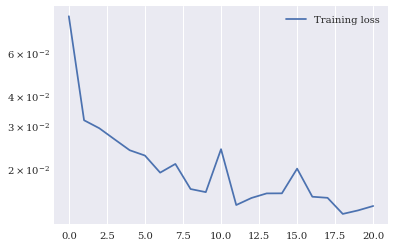

In [870]:
y_train_pred, y_train, y_test_pred, y_test, lstm = train(trial_lstm, "LSTM")

In [871]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('LSTM Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('LSTM Test Score: %.2f RMSE' % (testScore))

LSTM Train Score: 169.92 RMSE
LSTM Test Score: 153.24 RMSE


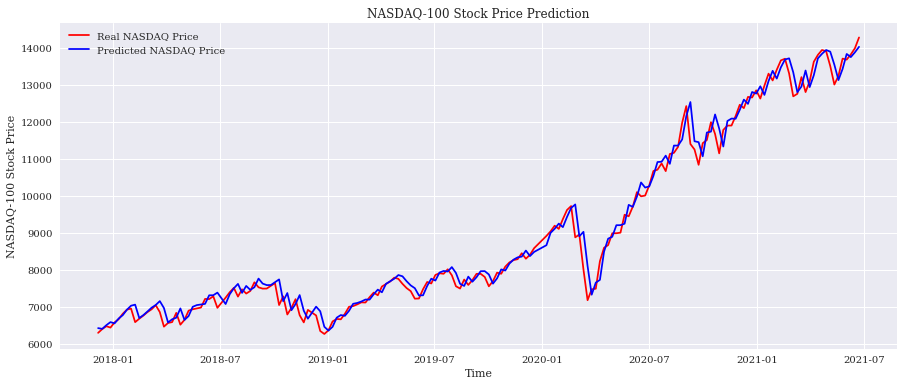

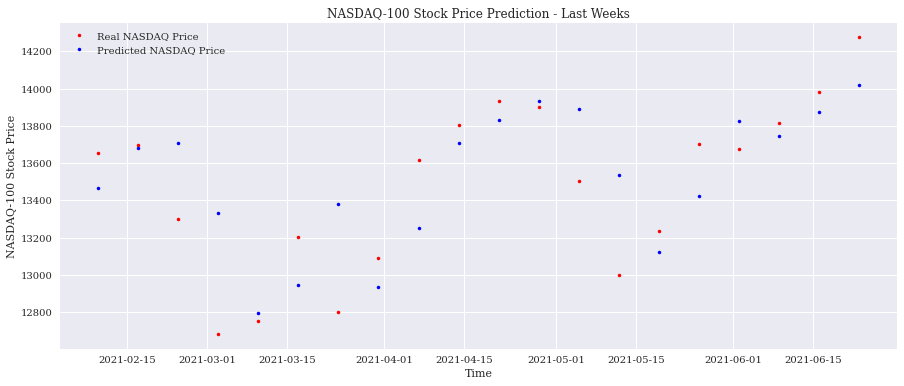

In [872]:
plot_results(lstm, batch_size = trial_lstm.params['Batch Size'])

[14279.720703125, 14257.263671875, 14249.8349609375, 14257.0537109375, 14277.1142578125]


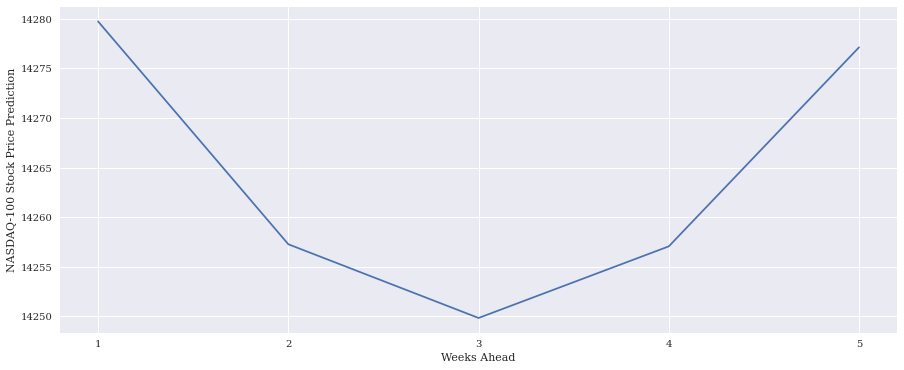

In [873]:
predict_results(lstm)

# Naive Predictor

In [874]:
dt = nasdaq.index[-1]-nasdaq.index[0]
dt = int(dt.days/7)
avg_weekly_gain = (nasdaq.iloc[-1,0]/nasdaq.iloc[0,0])**(1/dt)
#dt = len(nasdaq)
print('Nasdaq avegage weekly gain: %.4f' % (avg_weekly_gain))
dates = nasdaq.index
d0 = dates[0]
#naive = nasdaq.iloc[0,0]*avg_weekly_gain**((dates-d0).days/7)
naive = nasdaq['Close']*avg_weekly_gain
naiveScore = math.sqrt(mean_squared_error(naive[:-1], nasdaq['Close'][1:]))
print('Naive Predictor Score: %.2f RMSE' % (naiveScore))

Nasdaq avegage weekly gain: 1.0027
Naive Predictor Score: 131.68 RMSE


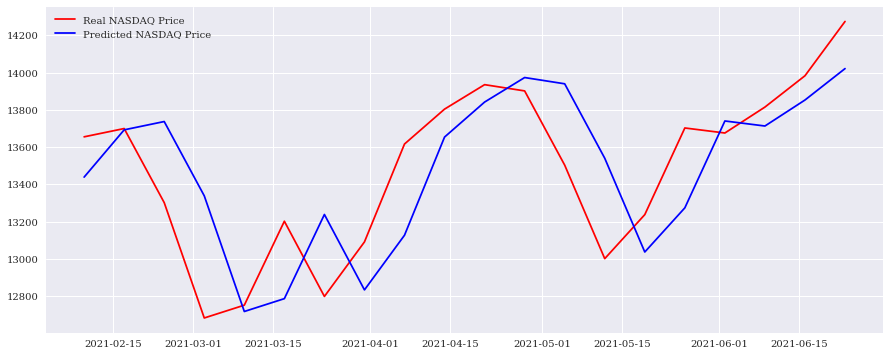

In [875]:
figure, axes = plt.subplots(figsize=(15, 6))
last = 20
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, nasdaq['Close'][-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, naive[-last-1:-1], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

# Prediction with GRU without Fed Data

In [876]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1

In [877]:
study_gru_no_fed = conduct_study ('GRU NO FED', 'GRU')

[I 2021-06-26 00:26:12,081] A new study created in memory with name: GRU NO FED
[I 2021-06-26 00:26:28,451] Trial 0 finished with value: 0.011815980076789856 and parameters: {'Look Back': 35, 'Batch Size': 64, 'Hidden Dim': 256, 'N layers': 3, 'Learning Rate': 0.0039019758537347377, 'Factor': 0.95}. Best is trial 0 with value: 0.011815980076789856.
[I 2021-06-26 00:26:33,819] Trial 1 finished with value: 0.013996189460158348 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 128, 'N layers': 1, 'Learning Rate': 0.0013585258808924143, 'Factor': 0.65}. Best is trial 0 with value: 0.011815980076789856.
[I 2021-06-26 00:26:40,298] Trial 2 finished with value: 0.010901737958192825 and parameters: {'Look Back': 40, 'Batch Size': 64, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.013065318726725788, 'Factor': 0.95}. Best is trial 2 with value: 0.010901737958192825.
[I 2021-06-26 00:26:44,955] Trial 3 finished with value: 0.01134780328720808 and parameters: {'Look Back': 2

[I 2021-06-26 00:28:08,349] Trial 72 finished with value: 0.009741238318383694 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.009426936609786666, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008801519870758057.
[I 2021-06-26 00:28:13,227] Trial 73 finished with value: 0.009629636071622372 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.00430896591757125, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008801519870758057.
[I 2021-06-26 00:28:13,359] Trial 74 pruned. 
[I 2021-06-26 00:28:13,823] Trial 75 pruned. 
[I 2021-06-26 00:28:14,067] Trial 76 pruned. 
[I 2021-06-26 00:28:14,319] Trial 77 pruned. 
[I 2021-06-26 00:28:14,995] Trial 78 pruned. 
[I 2021-06-26 00:28:15,216] Trial 79 pruned. 
[I 2021-06-26 00:28:15,585] Trial 80 pruned. 
[I 2021-06-26 00:28:20,494] Trial 81 finished with value: 0.00965852104127407 and parameters: {'Look Back': 2

[I 2021-06-26 00:29:39,280] Trial 142 pruned. 
[I 2021-06-26 00:29:39,413] Trial 143 pruned. 
[I 2021-06-26 00:29:39,650] Trial 144 pruned. 
[I 2021-06-26 00:29:39,904] Trial 145 pruned. 
[I 2021-06-26 00:29:39,957] Trial 146 pruned. 
[I 2021-06-26 00:29:40,405] Trial 147 pruned. 
[I 2021-06-26 00:29:40,544] Trial 148 pruned. 
[I 2021-06-26 00:29:40,689] Trial 149 pruned. 
[I 2021-06-26 00:29:40,826] Trial 150 pruned. 
[I 2021-06-26 00:29:40,967] Trial 151 pruned. 
[I 2021-06-26 00:29:46,073] Trial 152 finished with value: 0.009679113514721394 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006693876419301755, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008801519870758057.
[I 2021-06-26 00:29:50,738] Trial 153 finished with value: 0.00993524119257927 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006480444977827063, 'Factor': 0.8500000000000001}. Best is tr

[I 2021-06-26 00:30:41,839] Trial 239 pruned. 
[I 2021-06-26 00:30:42,073] Trial 240 pruned. 
[I 2021-06-26 00:30:42,308] Trial 241 pruned. 
[I 2021-06-26 00:30:42,435] Trial 242 pruned. 
[I 2021-06-26 00:30:42,662] Trial 243 pruned. 
[I 2021-06-26 00:30:42,895] Trial 244 pruned. 
[I 2021-06-26 00:30:43,048] Trial 245 pruned. 
[I 2021-06-26 00:30:43,184] Trial 246 pruned. 
[I 2021-06-26 00:30:43,356] Trial 247 pruned. 
[I 2021-06-26 00:30:43,484] Trial 248 pruned. 
[I 2021-06-26 00:30:43,538] Trial 249 pruned. 
[I 2021-06-26 00:30:47,989] Trial 250 finished with value: 0.009725055657327175 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006620058790606097, 'Factor': 0.8500000000000001}. Best is trial 20 with value: 0.008801519870758057.
[I 2021-06-26 00:30:48,193] Trial 251 pruned. 
[I 2021-06-26 00:30:48,325] Trial 252 pruned. 
[I 2021-06-26 00:30:48,451] Trial 253 pruned. 
[I 2021-06-26 00:30:48,533] Trial 254 pruned. 
[I 2021-0

[I 2021-06-26 00:31:36,458] Trial 344 pruned. 
[I 2021-06-26 00:31:36,513] Trial 345 pruned. 
[I 2021-06-26 00:31:36,644] Trial 346 pruned. 
[I 2021-06-26 00:31:36,867] Trial 347 pruned. 
[I 2021-06-26 00:31:36,994] Trial 348 pruned. 
[I 2021-06-26 00:31:37,127] Trial 349 pruned. 
[I 2021-06-26 00:31:37,268] Trial 350 pruned. 
[I 2021-06-26 00:31:37,411] Trial 351 pruned. 
[I 2021-06-26 00:31:37,657] Trial 352 pruned. 
[I 2021-06-26 00:31:37,794] Trial 353 pruned. 
[I 2021-06-26 00:31:37,927] Trial 354 pruned. 
[I 2021-06-26 00:31:37,983] Trial 355 pruned. 
[I 2021-06-26 00:31:38,067] Trial 356 pruned. 
[I 2021-06-26 00:31:38,202] Trial 357 pruned. 
[I 2021-06-26 00:31:38,329] Trial 358 pruned. 
[I 2021-06-26 00:31:38,460] Trial 359 pruned. 
[I 2021-06-26 00:31:38,589] Trial 360 pruned. 
[I 2021-06-26 00:31:38,633] Trial 361 pruned. 
[I 2021-06-26 00:31:39,281] Trial 362 pruned. 
[I 2021-06-26 00:31:39,406] Trial 363 pruned. 
[I 2021-06-26 00:31:39,582] Trial 364 pruned. 
[I 2021-06-26

[I 2021-06-26 00:32:30,368] Trial 453 pruned. 
[I 2021-06-26 00:32:30,455] Trial 454 pruned. 
[I 2021-06-26 00:32:30,730] Trial 455 pruned. 
[I 2021-06-26 00:32:30,880] Trial 456 pruned. 
[I 2021-06-26 00:32:31,559] Trial 457 pruned. 
[I 2021-06-26 00:32:31,707] Trial 458 pruned. 
[I 2021-06-26 00:32:31,842] Trial 459 pruned. 
[I 2021-06-26 00:32:31,978] Trial 460 pruned. 
[I 2021-06-26 00:32:32,117] Trial 461 pruned. 
[I 2021-06-26 00:32:32,167] Trial 462 pruned. 
[I 2021-06-26 00:32:32,307] Trial 463 pruned. 
[I 2021-06-26 00:32:32,372] Trial 464 pruned. 
[I 2021-06-26 00:32:32,530] Trial 465 pruned. 
[I 2021-06-26 00:32:32,889] Trial 466 pruned. 
[I 2021-06-26 00:32:33,101] Trial 467 pruned. 
[I 2021-06-26 00:32:33,435] Trial 468 pruned. 
[I 2021-06-26 00:32:33,702] Trial 469 pruned. 
[I 2021-06-26 00:32:38,268] Trial 470 finished with value: 0.009703721851110458 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.00659108576683318

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  438
  Number of complete trials:  62


In [878]:
optuna.visualization.plot_param_importances(study_gru_no_fed)

In [879]:
print("Best trial:")
trial_gru_no_fed = study_gru_no_fed.best_trial

print("Loss: ", trial_gru_no_fed.value)
print(trial_gru_no_fed.params)

Best trial:
Loss:  0.008801519870758057
{'Look Back': 15, 'Batch Size': 64, 'Hidden Dim': 32, 'N layers': 2, 'Learning Rate': 0.021609214541306106, 'Factor': 0.8500000000000001}


Epoch  0 MSE:  0.2095730291057296
Epoch  20 MSE:  0.01246418776154119
Epoch  40 MSE:  0.010363122089798052
Epoch  60 MSE:  0.010712998335335637
Epoch  80 MSE:  0.010139495679974018
Last Epoch  99 MSE:  0.009537781642957262


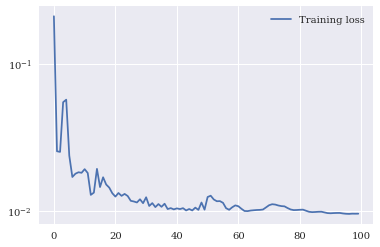

In [880]:
y_train_pred, y_train, y_test_pred, y_test, gru_no_fed = train(trial_gru_no_fed, "GRU")

In [881]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('GRU without fed Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('GRU without fed Test Score: %.2f RMSE' % (testScore))

GRU without fed Train Score: 132.47 RMSE
GRU without fed Test Score: 125.63 RMSE


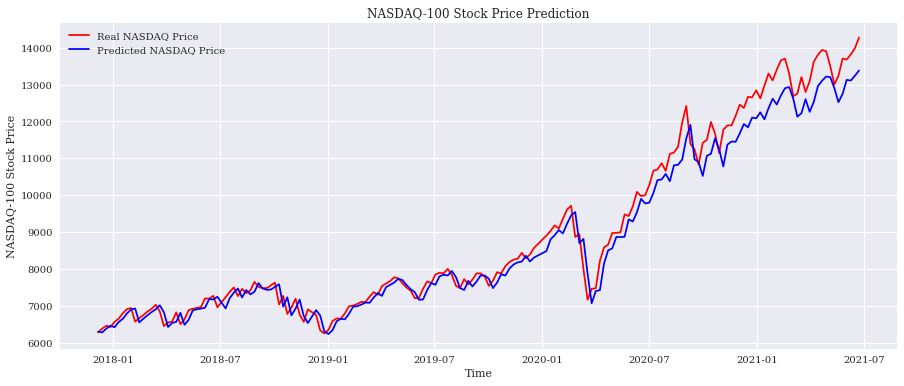

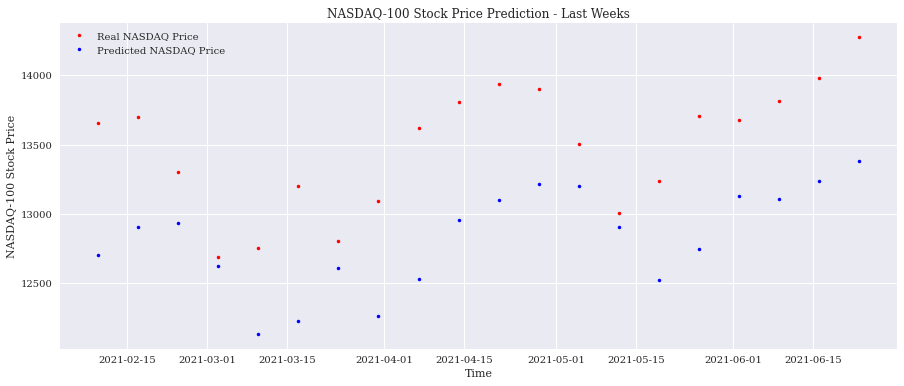

In [882]:
plot_results(gru_no_fed, batch_size = trial_gru_no_fed.params['Batch Size'])

[13596.2578125, 13073.7412109375, 12677.4970703125, 12381.4130859375, 12147.013671875]


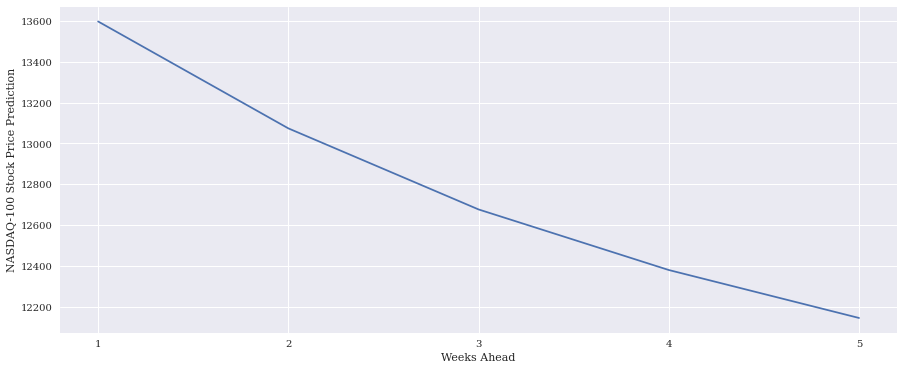

In [892]:
predict_results(gru_no_fed)

# Prediction with LSTM without Fed Data

In [884]:
study_lstm_no_fed = conduct_study('LSTM NO FED', 'LSTM')

[I 2021-06-26 00:32:54,263] A new study created in memory with name: LSTM NO FED
[I 2021-06-26 00:32:56,471] Trial 0 finished with value: 0.010620207525789738 and parameters: {'Look Back': 40, 'Batch Size': 128, 'Hidden Dim': 8, 'N layers': 1, 'Learning Rate': 0.05646268972532677, 'Factor': 0.55}. Best is trial 0 with value: 0.010620207525789738.
[I 2021-06-26 00:33:03,189] Trial 1 finished with value: 0.012240455485880375 and parameters: {'Look Back': 40, 'Batch Size': 16, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.00038571528789157464, 'Factor': 0.95}. Best is trial 0 with value: 0.010620207525789738.
[I 2021-06-26 00:33:08,137] Trial 2 finished with value: 0.009749678894877434 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.019993036415512765, 'Factor': 0.55}. Best is trial 2 with value: 0.009749678894877434.
[I 2021-06-26 00:33:12,221] Trial 3 finished with value: 0.013401282019913197 and parameters: {'Look Back': 45

[I 2021-06-26 00:34:02,377] Trial 93 pruned. 
[I 2021-06-26 00:34:02,802] Trial 94 pruned. 
[I 2021-06-26 00:34:03,269] Trial 95 pruned. 
[I 2021-06-26 00:34:03,348] Trial 96 pruned. 
[I 2021-06-26 00:34:03,485] Trial 97 pruned. 
[I 2021-06-26 00:34:03,717] Trial 98 pruned. 
[I 2021-06-26 00:34:03,940] Trial 99 pruned. 
[I 2021-06-26 00:34:03,983] Trial 100 pruned. 
[I 2021-06-26 00:34:04,214] Trial 101 pruned. 
[I 2021-06-26 00:34:04,435] Trial 102 pruned. 
[I 2021-06-26 00:34:04,845] Trial 103 pruned. 
[I 2021-06-26 00:34:05,063] Trial 104 pruned. 
[I 2021-06-26 00:34:09,493] Trial 105 finished with value: 0.010431865230202675 and parameters: {'Look Back': 20, 'Batch Size': 16, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.03039229663810365, 'Factor': 0.55}. Best is trial 4 with value: 0.009103862568736076.
[I 2021-06-26 00:34:09,635] Trial 106 pruned. 
[I 2021-06-26 00:34:09,895] Trial 107 pruned. 
[I 2021-06-26 00:34:13,107] Trial 108 pruned. 
[I 2021-06-26 00:34:13,229] Tria

[I 2021-06-26 00:35:01,412] Trial 204 finished with value: 0.011339670978486538 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.017778964022323613, 'Factor': 0.65}. Best is trial 4 with value: 0.009103862568736076.
[I 2021-06-26 00:35:01,597] Trial 205 pruned. 
[I 2021-06-26 00:35:01,735] Trial 206 pruned. 
[I 2021-06-26 00:35:01,791] Trial 207 pruned. 
[I 2021-06-26 00:35:02,024] Trial 208 pruned. 
[I 2021-06-26 00:35:07,092] Trial 209 finished with value: 0.010858709923923016 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.01782699453592035, 'Factor': 0.95}. Best is trial 4 with value: 0.009103862568736076.
[I 2021-06-26 00:35:07,235] Trial 210 pruned. 
[I 2021-06-26 00:35:07,369] Trial 211 pruned. 
[I 2021-06-26 00:35:10,115] Trial 212 pruned. 
[I 2021-06-26 00:35:10,270] Trial 213 pruned. 
[I 2021-06-26 00:35:10,417] Trial 214 pruned. 
[I 2021-06-26 00:35:10,697] Trial 21

[I 2021-06-26 00:35:51,955] Trial 319 pruned. 
[I 2021-06-26 00:35:52,240] Trial 320 pruned. 
[I 2021-06-26 00:35:52,382] Trial 321 pruned. 
[I 2021-06-26 00:35:52,647] Trial 322 pruned. 
[I 2021-06-26 00:35:52,718] Trial 323 pruned. 
[I 2021-06-26 00:35:52,991] Trial 324 pruned. 
[I 2021-06-26 00:35:53,040] Trial 325 pruned. 
[I 2021-06-26 00:35:53,189] Trial 326 pruned. 
[I 2021-06-26 00:35:53,333] Trial 327 pruned. 
[I 2021-06-26 00:35:53,603] Trial 328 pruned. 
[I 2021-06-26 00:35:53,748] Trial 329 pruned. 
[I 2021-06-26 00:35:54,046] Trial 330 pruned. 
[I 2021-06-26 00:35:54,202] Trial 331 pruned. 
[I 2021-06-26 00:35:54,380] Trial 332 pruned. 
[I 2021-06-26 00:35:54,662] Trial 333 pruned. 
[I 2021-06-26 00:35:54,720] Trial 334 pruned. 
[I 2021-06-26 00:35:54,876] Trial 335 pruned. 
[I 2021-06-26 00:35:55,029] Trial 336 pruned. 
[I 2021-06-26 00:35:59,439] Trial 337 finished with value: 0.010880520567297935 and parameters: {'Look Back': 10, 'Batch Size': 8, 'Hidden Dim': 16, 'N la

[I 2021-06-26 00:37:01,123] Trial 423 finished with value: 0.009861701168119907 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.017545987349948028, 'Factor': 0.55}. Best is trial 4 with value: 0.009103862568736076.
[I 2021-06-26 00:37:01,289] Trial 424 pruned. 
[I 2021-06-26 00:37:01,444] Trial 425 pruned. 
[I 2021-06-26 00:37:01,603] Trial 426 pruned. 
[I 2021-06-26 00:37:01,760] Trial 427 pruned. 
[I 2021-06-26 00:37:01,910] Trial 428 pruned. 
[I 2021-06-26 00:37:02,059] Trial 429 pruned. 
[I 2021-06-26 00:37:02,207] Trial 430 pruned. 
[I 2021-06-26 00:37:02,365] Trial 431 pruned. 
[I 2021-06-26 00:37:02,520] Trial 432 pruned. 
[I 2021-06-26 00:37:02,674] Trial 433 pruned. 
[I 2021-06-26 00:37:02,822] Trial 434 pruned. 
[I 2021-06-26 00:37:02,920] Trial 435 pruned. 
[I 2021-06-26 00:37:03,069] Trial 436 pruned. 
[I 2021-06-26 00:37:03,223] Trial 437 pruned. 
[I 2021-06-26 00:37:03,382] Trial 438 pruned. 
[I 2021-06-26 00:37:03,4

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  462
  Number of complete trials:  38


In [885]:
optuna.visualization.plot_param_importances(study_lstm_no_fed)

In [886]:
print("Best trial:")
trial_lstm_no_fed = study_lstm_no_fed.best_trial

print("Loss: ", trial_lstm_no_fed.value)
print(trial_lstm_no_fed.params)

Best trial:
Loss:  0.009103862568736076
{'Look Back': 15, 'Batch Size': 16, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.0032072973066584716, 'Factor': 0.55}


Epoch  0 MSE:  0.1879326886410773
Epoch  20 MSE:  0.016030795695432396
Epoch  40 MSE:  0.012730065344079937
Last Epoch  40 MSE:  0.012730065344079937


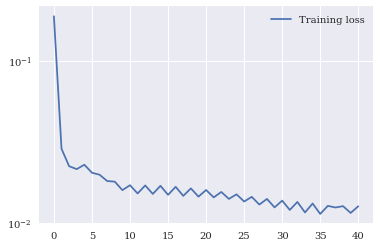

In [887]:
y_train_pred, y_train, y_test_pred, y_test, lstm_no_fed = train(trial_lstm_no_fed, "LSTM")

In [888]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('LSTM without fed Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('LSTM without fed Test Score: %.2f RMSE' % (testScore))

LSTM without fed Train Score: 151.57 RMSE
LSTM without fed Test Score: 153.24 RMSE


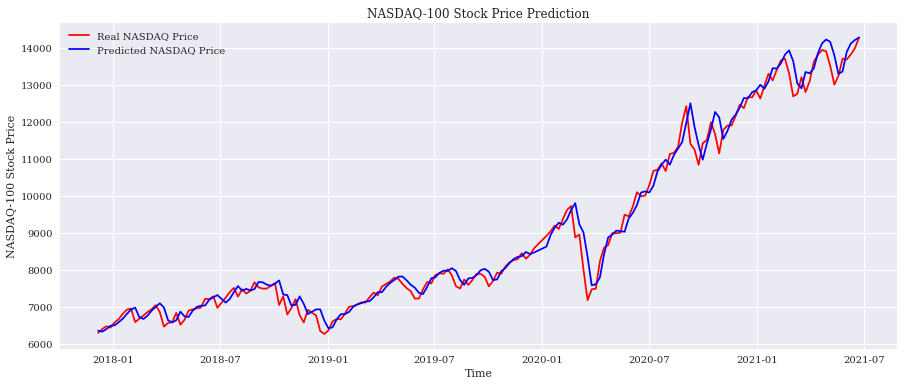

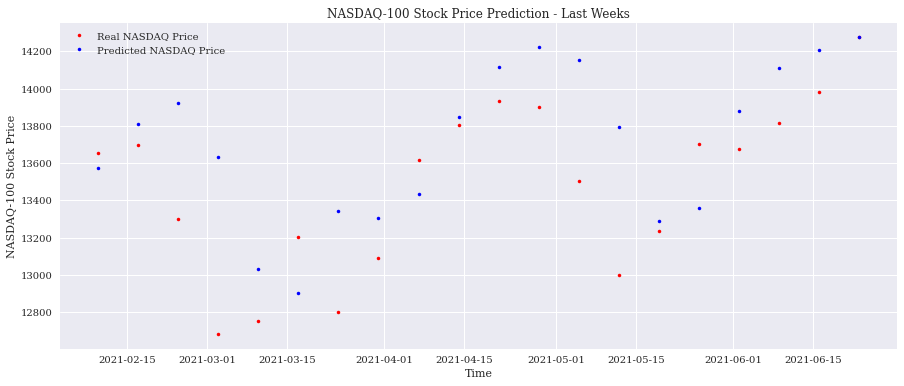

In [889]:
plot_results(lstm_no_fed, batch_size = trial_lstm_no_fed.params['Batch Size'])

[14468.2421875, 14669.5439453125, 14867.2216796875, 15055.517578125, 15233.666015625]


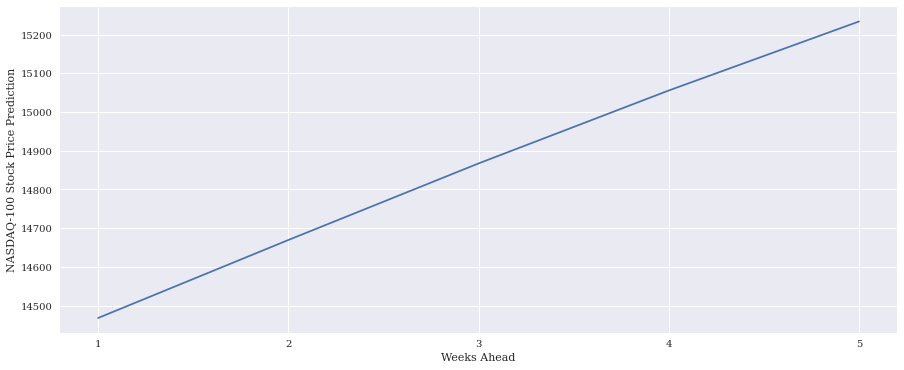

In [891]:
predict_results(lstm_no_fed)